Since last year's dive into my reading list was a fun experiment, I decided to do it again for 2021. I even added some extra columns in my table to check monthly tallies and indicate which books were my favourites. Here are some notes from my exploratory data analysis on the lastest batch of books.

In [1]:
import pandas as pd
import numpy as np

# Import the data
data2020 = pd.read_csv("https://rachel.ostic.ca/post/2020books/2020%20book%20table.csv")
data2021 = pd.read_csv("2021_book_table.csv")

I need to make the two tables consistent across the columns. In 2020 I kept a csv file with the list of books, this past year in 2021 I switched to a Notion database. The export settings from Notion give different formatting compared to my 2020 table, so I have to start by translating and cleaning the data to match the 2021 table.

There are two columns, **Reread?** and **Genres**, that need to be reformatted with string substitutions. From there, I concatenate the two tables into a single block called **books**.

In [2]:
# Make labels consistent across years 
data2020 = data2020.rename(columns={"Reading time (if known)": "Reading time", 
                                    "Note": "Genres",
                                    "Count": "Order"})
# Add reading year indicator
data2020["Read in"] = 2020
data2021["Read in"] = 2021

# Formatting stuff for a couple columns
data2020["Reread?"].replace({0: "No", 1: "Yes"}, inplace=True)
data2020["Genres"] = data2020["Genres"].str.replace(";", ",")
data2020["Genres"] = data2020["Genres"].str.replace("classics", "classic")
data2020["Genres"] = data2020["Genres"].str.replace("tales", "tale")
data2020["Genres"] = data2020["Genres"].str.replace("tales", "tale")
data2020["Genres"] = data2020["Genres"].str.replace("story", "stories")
data2020["Genres"] = data2020["Genres"].str.replace("’", "'")

# Concatenate into one table
books = data2021.append(data2020, ignore_index=True)
list(books)

['Order',
 'Title',
 'Author',
 'Year',
 'Genres',
 'Number of pages',
 'Reading time',
 'Reread?',
 'Month finished',
 'Favourite?',
 'Read in']

# Reread books
First question: did I reread any old favourites in 2021?

In [3]:
books[(books["Read in"]==2021) & (books["Reread?"]=="Yes")][["Title", "Favourite?"]].sort_values(["Favourite?"])

,Title,Favourite?
59,Elsewhere,No
72,The Two Princesses of Bamarre,No
83,City of Masks,No
94,Les Liaisons dangereuses,No
98,The Alchemist,No
55,The House of All Sorts,Yes
58,The Storied Life of A.J. Fikry,Yes
71,The Amulet of Samarkand,Yes
96,L'élégance du hérisson,Yes
104,A Little Princess,Yes


Yes. Of the books I reread, about half of them are old favourites. I also ended up reading relatively fewer books over again in 2021 compared to 2020.

In [4]:
def frac_reread(year):
  return len(books[(books["Read in"]==year) & (books["Reread?"]=="Yes")])/len(books[(books["Read in"]==year)])

f"Rereads were {frac_reread(2020)*100}% of books in 2020 vs. {frac_reread(2021)*100:.2f}% in 2021."

'Rereads were 20.0% of books in 2020 vs. 9.73% in 2021.'

# Divide up genres
I'm using the same approach as last year to one-hot encode the genre labels with the **MultiLabelBinarizer** from **sklearn**. One small peculiarity you might notice is that the split string is ", " with a space after the comma. Last year, I didn't need the space character since I always started my entries with either **fiction** or **nonfiction** and then added more specific labels. This time, that caused a problem with the Notion-exported database which puts the multilabels in alphabetical order, so I wound up with duplicates of the same label from having "fiction" and " fiction" as two different strings after the split. The additional space is my quick fix.

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

inputX = [element.split(', ') for element in books["Genres"]]

transformedX = mlb.fit_transform(inputX)
labels = [element.strip() for element in mlb.classes_]

genres = pd.DataFrame(transformedX, columns=labels)
books = pd.concat([books, genres], axis=1)

print(f"{len(labels)} genre labels as follow:")
labels

21 genre labels as follow:


['biography',
 "children's",
 'classic',
 'epistolary',
 'fairy tale',
 'fantasy',
 'fiction',
 'french',
 'german',
 'graphic novel',
 'historical fiction',
 'horror',
 'mystery',
 'nonfiction',
 'novella',
 'poetry',
 'romance',
 'science fiction',
 'short stories',
 'thriller',
 'young adult']

With this information in the table, I can look at how the distribution of these labels varies by month in 2021. Finding a suitable colour scheme is a bit challenging because there are more than 20 categories, so many of the discrete maps will end up having repeats. The [colormap reference](https://matplotlib.org/stable/tutorials/colors/colormaps.html) is handy though! I am using the built-in **tab20** map with an extra dark gray appended.

In [6]:
import matplotlib.pyplot as plt

# Tally genre labels by month in 2021
genre_distr = books[books["Read in"]==2021].groupby(["Month finished"], sort=False).sum()[labels]
genre_distr.head(3)

,biography,children's,classic,epistolary,fairy tale,fantasy,fiction,french,german,graphic novel,historical fiction,horror,mystery,nonfiction,novella,poetry,romance,science fiction,short stories,thriller,young adult
Month finished,,,,,,,,,,,,,,,,,,,,,
January,1,0,1,1,1,3,10,0,0,0,2,1,0,1,0,0,3,0,0,1,1
February,2,0,2,0,1,2,11,1,0,0,0,0,1,1,0,0,4,1,0,0,2
March,1,0,1,1,0,1,4,0,0,0,2,0,0,4,0,0,2,1,0,0,0


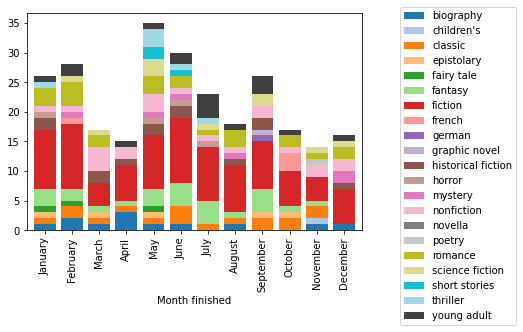

In [7]:
# Define colormap
colors = plt.get_cmap(name="tab20")(np.linspace(0,1,len(labels)))
colors[len(labels)-1, :] = [0.25,0.25,0.25,1]

# Plot
genre_distr.plot(kind="bar", 
                 stacked=True, 
                 color=colors, 
                 width=0.8)
plt.legend(labels, bbox_to_anchor=(1.1, 1.05))
plt.show()

The **pandas** plotting is very convenient here: the grouping by month and stacking of the bars is done automatically. For reference, the equivalent code that I found using only **matplotlib** is more cumbersome, requiring manually keeping track of the bar heights and looping over the different genre labels:

```
names = books[books['Read in']==2021]['Month finished'].unique()
xpos = range(1, len(names)+1)

y_offset = np.zeros(len(names))
for i, row in enumerate(labels):
    plt.bar(xpos, genre_distr[row], bottom=y_offset, color=colors[i,])
    y_offset = y_offset + genre_distr[row]
plt.legend(labels, bbox_to_anchor=(1.1, 1.05))
plt.xticks(xpos, names, rotation=90)
plt.show()
```

The issue with that representation is that the labels are not mututally exclusive: books have between 1 and 5 different genre tags. This means that the total for each month is incorrect. If I limit to the **fiction** and **nonfiction** categories of which a single one is applied to every book in the list, I can make the y axis show the real number of books I read each month.

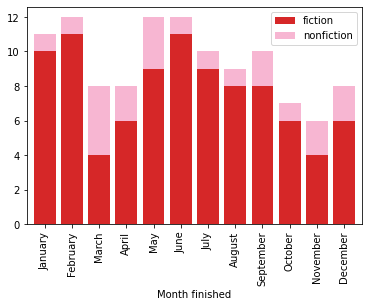

In [8]:
genre_distr[["fiction", "nonfiction"]].plot(kind="bar", stacked=True, 
                                          color=[colors[labels.index("fiction"),],colors[labels.index("nonfiction"),]], 
                                          width=0.8)
plt.legend(["fiction", "nonfiction"])
plt.show()

In 2021, I read between 6 and 12 books every month. The difference in y scale between the two previous plots shows why looking at the counts in different categories isn't the most informative: there's overlap between them! I went looking for ideas on how what libraries and types of visualizations work for generalizing Venn diagrams and found a [fun answer](https://stackoverflow.com/questions/10804432/proportional-venn-diagram-for-more-than-3-sets) using **networkx** graphs.

The nodes are going to be based on genre labels with weights associated to their frequencies. Edges show which pairs have been used in tandem in my tables. First step is to get the nodes and edges. The scale factor controls the overall size of the nodes. In this one I'm using the data from both 2020 and 2021 to see if there are recurring patterns in the labels I apply to books.

In [9]:
node_sizes = []
node_labels = {}
edges = []
edge_weights = []
node_scale_factor = 40

for i in range(len(labels)):
  # For each genre, count how many times it appears; this will determine the size of its node
  size = genres[labels[i]].value_counts()[1]
  node_sizes.append(size *node_scale_factor )
  # As well as the geometric size, the counts are also going to be part of the node labels
  node_labels[labels[i]] = labels[i] + "\n" + str(size)
  # Next look at the pairwise intersections with other genres
  for j in range(i+1, len(labels)):
    # Count how many times the pair occurs simultaneously and save this for the weight
    intersections = len(genres[(genres[labels[i]]==1) & (genres[labels[j]]==1)])
    if intersections > 0:
      edges.append((labels[i], labels[j], {"weight": intersections}))
      edge_weights.append(intersections)

Next, make the graph! It is possible to draw all the components (nodes, edges, labels) in one function call, but I use more specific functions for better control over colours and details for each part.

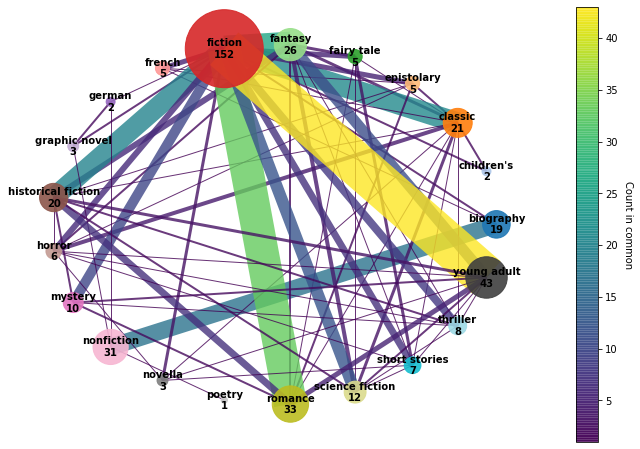

In [10]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from( labels )
G.add_edges_from( edges )
pos=nx.circular_layout(G)

plt.figure(1,figsize=(12,8)) 
edge_part = nx.draw_networkx_edges(G,
                             pos=pos,
                             width = edge_weights,
                             edge_color = edge_weights,
                             edge_cmap = plt.cm.viridis,
                             alpha=0.8,
                             )
nx.draw_networkx_nodes(G, 
                       pos=pos,
                       node_size = node_sizes,
                       node_color = colors,
                       alpha=0.9
                       )
nx.draw_networkx_labels(G, 
                        pos=pos,
                        labels=node_labels,
                        font_size = 10, 
                        font_weight = "bold", 
                        )
plt.axis("off")
cbar = plt.colorbar(edge_part)
cbar.ax.set_ylabel("Count in common",labelpad=15,rotation=270)
#plt.savefig('graph1.png',dpi=300,facecolor='white',edgecolor='white')
plt.show()

I experimented with a few different layout options for the graph. This circular one ended up looking the neatest in terms of readability of the node label and avoiding overlaps between nodes. It accidentally turned into a chord diagram! The thicker lines are the ones with the most pairwise intersections. The edges are colour-coded and partially transparent to give better contrast where they overlap. The main node is fiction which is most strongly associated with romance, young adult, fantasy, classic, and historical fiction. On the nonfiction side, a lot of the books are biographies. 

For displaying the graph, clipping was an issue until I manually increased the figsize a lot to fit in all the nodes and their labels.

Another thing I'm curious about given some of the more frequent counts in the graph is whether the books I marked as favourites fall in the those categories I clearly gravitate toward. Using the same grouping and summary approach as with the grouping by month, I can compare the set of book genres by whether or not they were added to my favourites list.

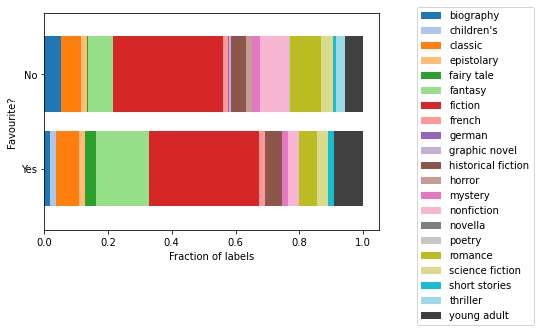

In [11]:
fav_distr = books[books["Read in"]==2021].groupby(["Favourite?"], sort=False).sum()[labels]
fav_distr = fav_distr.apply(lambda x: x/x.sum(), axis=1)

fav_distr.plot(kind="barh", 
               stacked=True, 
               color=colors, 
               width=0.8)
plt.legend(labels, bbox_to_anchor=(1.1, 1.05))
plt.xlabel("Fraction of labels")
plt.show()

Again, not very scientific because I am looking based on the number of genre labels applied, not by the number of books. But it's kind of illuminating in the sense that the frequency of each one (the width of the section) shows which genres I might be more likely to really enjoy. For example, fantasy and young adult occur more often in the favourites list compared with nonfiction, thriller, romance or horror which shrink in the **Yes** section. Lighthearted escapist books are more my style.

# Publication year
Next column to explore is the publication year. I use the original copyright date to avoid confusion in the case of subsequent editions or translation dates. I'm trying out **seaborn** for this since the **FacetGrid** and **hue** options are similar to the functionality of **ggplot** in R that I have recently come to appreciate for prototyping data visualizations.

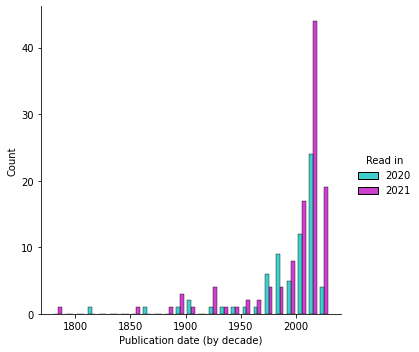

In [12]:
import seaborn as sns

# Set bins by decade from leftmost to rightmost edge
bins = range((books["Year"].min()//10)*10, (books["Year"].max()//10+2)*10, 10)

# Make plot
sns.displot(books, 
            x="Year", 
            bins=bins, 
            hue="Read in", 
            multiple="dodge", 
            palette=["c","m"], 
            kind="hist", 
            shrink=0.7)
plt.xlabel("Publication date (by decade)")
plt.show()

It turns out the "extra" books I read relative to 2020 are all from the last decade or so. The single 18th century point is *Les liaisons dangereuses*.

# Book titles
Something I didn't think to look at last year was book titles. 

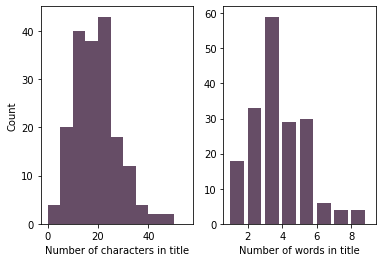

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2)
onecolor = [0.4,0.3,0.4]

ax1.hist(books["Title"].str.len(),
         bins=range(0,60,5),
         color=onecolor)
ax1.set_xlabel("Number of characters in title")
ax1.set_ylabel("Count")

ax2.hist(books["Title"].str.split().map(len),
         bins=range(1,10),
         width=0.8,
         color=onecolor)
ax2.set_xlabel("Number of words in title")
plt.show()

The most frequent are 3-word titles by a large margin. Most titles are also in the 15 to 25 character range (including spaces and punctuation).

# Page count
I'm reusing the code from last year to convert the hours:minutes format to the number of minutes.

In [14]:
def timetominutes(t):
  h, m = t.split(":")
  return int(h) * 60 + int(m) 

books["Reading time"] = books[books["Reading time"].notna()]["Reading time"].apply(timetominutes)

With this done, here is a view of the reading time as a function of the page count.

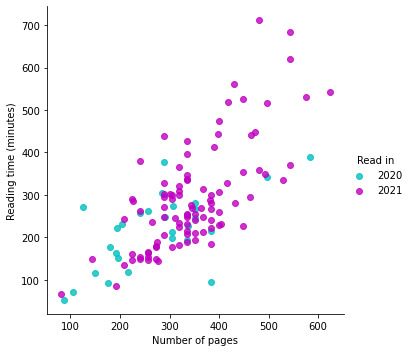

In [15]:
sns.lmplot(x="Number of pages", 
           y="Reading time", 
           data=books, 
           hue="Read in",
           palette=["c","m"],  
           fit_reg=False)
plt.ylabel("Reading time (minutes)")
plt.show()

A peculiar observation is that the number of pages is not as random as one might expect: you can kind of see the points are vertically aligned in places for frequently-occurring page counts. I read mainly in ebook format this past year and looked up the number of pages online. It's possible that printers have standard mockups and the formatting is made to fit within that number of pages.

For context, here is the count for the 10 most frequent numbers in the "Number of pages" column over 2020 and 2021 combined.

In [16]:
books["Number of pages"].value_counts().head(10)

336    14
288     9
320     8
240     7
384     7
352     7
256     6
304     6
224     5
400     5
Name: Number of pages, dtype: int64

# Reading rate
One of the less user-friendly aspects of **seaborn** is that as far as I can tell, there's [no way to access fit parameters](https://stackoverflow.com/questions/22852244/how-to-get-the-numerical-fitting-results-when-plotting-a-regression-in-seaborn/22852265#22852265) - they're just there as a guide to the eye. To get an average reading rate, I use all the data from 2020 and 2021 (based on the plot above the page count to reading time proportionality hasn't changed significantly - I just have more data).

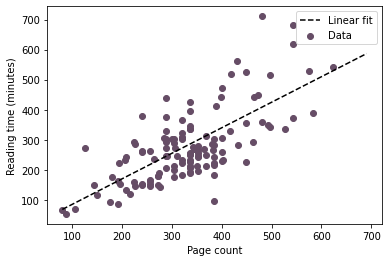

In [19]:
import scipy.optimize as opt

# Linear fit with 0 intercept
def prop(x, a):
     return a*x

# Fitting
params, pcov = opt.curve_fit(prop, 
                             books.dropna()["Number of pages"], 
                             books.dropna()["Reading time"])
x_data = range(books["Number of pages"].min(), books["Number of pages"].max())

# Plot data and fit
plt.plot(x_data, 
         prop(x_data, params[0]), 
         linestyle="dashed", 
         color="k", 
         label="Linear fit")
plt.scatter(books["Number of pages"], 
            books["Reading time"], 
            label="Data",
            color=onecolor)
plt.xlabel("Page count")
plt.ylabel("Reading time (minutes)")
plt.legend()
plt.show()

This fit lets me estimate a total reading time for the year 2021.

In [22]:
print(f"Approximately {round(params[0],3)} minutes per page")
total_time = books["Number of pages"].sum() * params[0]
print(f"Total: {books['Number of pages'].sum()} pages or {round(total_time/365,2)} minutes per day")

Approximately 0.849 minutes per page
Total: 59218 pages or 137.78 minutes per day


That's about 2 hours per day on average! I guess it's not surprising giving that reading has been one of my main pastimes. I'm curious about the increase from 0.75 to 0.85 minutes per page since last year. Maybe from reading more challenging material, maybe from being more distracted by finishing my degree.

To see the difference between 2020 and 2021 a little better, I can also look at the reading rate on a book-by-book basis.

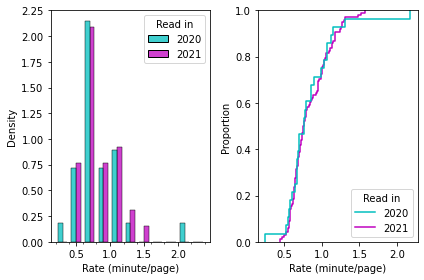

In [23]:
books["Rate"] = books["Reading time"] / books["Number of pages"]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
bins = np.linspace(start=0.2, stop=2.4, num=12)

sns.histplot(books, 
            x="Rate", 
            bins=bins, 
            hue="Read in", 
            multiple="dodge", 
            palette=["c","m"], 
            stat="density", 
            common_norm=False,
            shrink=0.7,
            ax=ax1)
ax1.set_xlabel("Rate (minute/page)")
ax1.set_xticks(bins, minor=True)

sns.ecdfplot(books, 
             x="Rate", 
             hue="Read in", 
             palette=["c","m"], 
             ax=ax2)
ax2.set_xlabel("Rate (minute/page)")
plt.tight_layout()
plt.show()

The distribution of reading rates from both years is very similar. Maybe just using the average would be a better aggregate measure than the fit? 

In [25]:
print(f"In 2020: average {round(books[books['Read in']==2020]['Rate'].mean(),3)} minutes per page")
print(f"In 2021: average {round(books[books['Read in']==2021]['Rate'].mean(),3)} minutes per page")

In 2020: average 0.837 minutes per page
In 2021: average 0.84 minutes per page


This seems like a more reliable way to quantify my average reading rate. It's nice to think about issues like these where my first idea isn't always the best and coming back a year later has given me a chance to deepen some of the analysis and improve my skills. It also gives me more data to try testing a hypothesis I had that older books are denser and the reading rate will be slower.

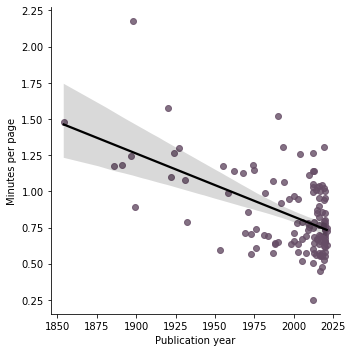

In [26]:
sns.lmplot(x="Year", y="Rate", data=books, line_kws={"color": "k"}, scatter_kws={"color": onecolor})
plt.ylabel("Minutes per page")
plt.xlabel("Publication year")
plt.show()

# Predict reading rate?
Last year, I was having a hard time finding interesting predictions to experiment with. Based on the last plot, I suspect that the reading rate has some dependence on the publication year. Maybe the genres are also a clue as to how long it will take for me to read a book! 


Table X will have all the predictors turned into numeric (or numeric boolean) form. 

In [27]:
X = books.dropna()[["Year", "Number of pages", "Reread?", "Favourite?"] + labels]
X["Reread?"].replace({"No":0, "Yes":1}, inplace=True)
X["Favourite?"].replace({"No":0, "Yes":1}, inplace=True)

y = books.dropna()["Reading time"]

Time to run the regression model and find a fit for y.

In [28]:
from sklearn import linear_model

# Fit
regr = linear_model.LinearRegression()
regr.fit(X, y)

# Results
print("Intercept: \n", regr.intercept_)
print("Coefficients:")
for name, val in zip(X.columns, regr.coef_):
  print(f"{name:20s} {val:10.3f}")
print("R squared score: \n", regr.score(X, y))

Intercept: 
 2560.6690648081126
Coefficients:
Year                     -1.299
Number of pages           1.022
Reread?                -105.644
Favourite?               38.520
biography               -42.553
children's               -0.000
classic                  -0.751
epistolary               -6.853
fairy tale              -44.173
fantasy                  47.655
fiction                 -32.715
french                  135.050
german                    0.000
graphic novel             0.000
historical fiction       32.759
horror                  -61.519
mystery                  12.867
nonfiction               32.715
novella                   0.000
poetry                  -19.516
romance                 -45.217
science fiction          -9.806
short stories            11.977
thriller                 -4.722
young adult             -24.735
R squared score: 
 0.7541174778666697


The R score is an improvement over last year's attempt.
At that time I hadn't read enough ebooks to try something like this. In the fit parameters the genre labels that appear very infrequently are not considered useful information since they have a coefficients 0. For interpreting this, the positive coefficients indicate that having that trait is associated with longer reading times. Negative values are indicative of shorter reading times. If I am rereading a book, that shortens the temporal duration (which matches my intuition based on experience). It's reassuring to see that the number of pages has a coefficient very close to 1: the time it takes to read a book should be directly proportional to its length. The publication year has the expected effect: more recent books are quicker to read.

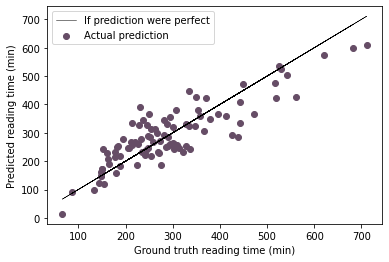

Average error 49.6 minutes
Min error 0.0 minutes
Max error 160.7 minutes


In [29]:
plt.plot(y, 
         y, 
         color="k", 
         linewidth=0.5,
         label="If prediction were perfect")
plt.scatter(y, 
            regr.predict(X),
            color=onecolor,
            label="Actual prediction")
plt.legend()
plt.xlabel("Ground truth reading time (min)")
plt.ylabel("Predicted reading time (min)")
plt.show()

print(f"Average error {round(np.mean(abs(y-regr.predict(X))),1)} minutes")
print(f"Min error {round(np.min(abs(y-regr.predict(X))),1)} minutes")
print(f"Max error {round(np.max(abs(y-regr.predict(X))),1)} minutes")

Interestingly, if you try the same thing with y as the rate instead of the time, the R score drops to 0.5 but the error statistics on the reading time (=rate$\times$number of pages) are nearly identical:

R squared score: 
 0.5086402177551403


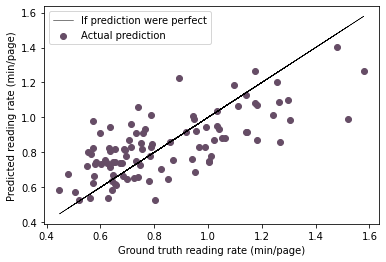

Average error 47.7 minutes
Min error 0.0 minutes
Max error 164.9 minutes


In [30]:
y = books.dropna()["Rate"]

# Fit
regr.fit(X, y)

# Results
print("R squared score: \n", regr.score(X, y))

plt.plot(y, 
         y, 
         color="k", 
         linewidth=0.5,
         label="If prediction were perfect")
plt.scatter(y, 
            regr.predict(X),
            color=onecolor,
            label="Actual prediction")
plt.legend()
plt.xlabel("Ground truth reading rate (min/page)")
plt.ylabel("Predicted reading rate (min/page)")
plt.show()

print(f"Average error {round(np.mean(abs(books.dropna()['Reading time']-regr.predict(X)*books.dropna()['Number of pages'])),1)} minutes")
print(f"Min error {round(np.min(abs(books.dropna()['Reading time']-regr.predict(X)*books.dropna()['Number of pages'])),1)} minutes")
print(f"Max error {round(np.max(abs(books.dropna()['Reading time']-regr.predict(X)*books.dropna()['Number of pages'])),1)} minutes")

This concludes my look back on my 2021 reading list. I've tried out a couple more visualization libraries since the 2020 edition. I hope that my enjoyment of reading endures and that I will continue to learn as I go along.